# Transfer Learning using MobileNetV2

This notebook illustrates the following:
- A simple example of data augmentation
- A quick demo of MobileNetV2. https://arxiv.org/abs/1704.04861
- Downloading and using a NN that is already trained for a specific application.
- Transfer Learning: Changing the purpose of an already train NN model:
   - Modifying the last layers so that it can be used for another application.
   - Locking or unlocking some of its layers so that the weigths of those layers can be re-trained for the new application.

Data for this notebook is download from Kaggle at: https://www.kaggle.com/datasets/sid4sal/alpaca-dataset-small

MobileNetV2 has 1000 classes for object identification/classification but no Alpaca! 🤦 🤦 🤦 How come? What if we want to detect Alpaca's? 🤷 🤷 🤷

In [1]:
import os
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import tensorflow as tf
from keras import layers
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory

## Loading the data

'image_dataset_from_directory' is a useful keras method that can read an image dataset from a folder and would label them based on their subfolders. It can also split the data into training and validation sets. It would also resize them based on the 'image_size' parameter.

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = os.getcwd() + "\Data\Alpaca\\"
train_dataset = image_dataset_from_directory(directory, 
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed = 10)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed = 10)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


## Data Inspection

As usual, we check the data that is loaded by visualizing some of them together with their labels

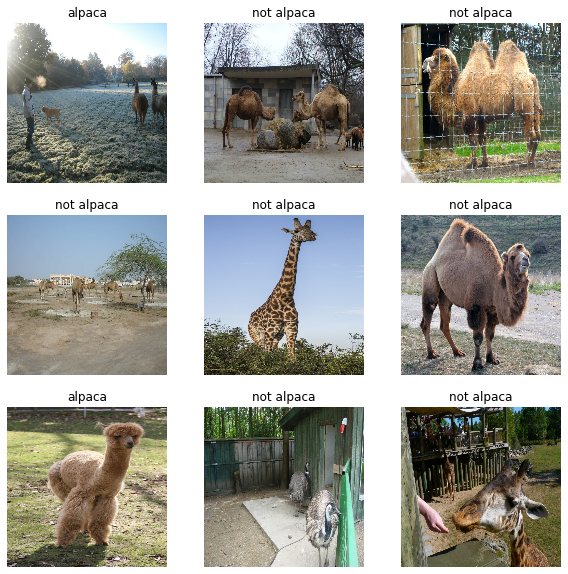

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data prefetch

When reading a lot of data from the disk, we usually want to avoid waiting for the data to be read from the disk into memory. This can be done by doing prefetch. The goal of is to make data available in the cache before the data is need, thereby masking the latency of the disk below the cache.

We can set the number of elements to be prefetch manually ot use tf.data.experimental.AUTOTUNE

In [4]:
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

## Data Augmentation

When the dataset available is small, it is very common to use data augmentation. Data augmentation means creating more training and test data using the available data, by applying some transformation to them. For example, an image can be rotated or flipped. The NN would be trained on these larger dataset. Another advantage is that data augmentation can reduce overfitting by increasing the diversity in the training population.

To augment the data the function below is created to randomly flip and rotated each image. We can see the result below. Some other available functions for data augmentation can be found at: https://www.tensorflow.org/tutorials/images/data_augmentation

In [5]:
def my_data_augmenter():
    
    augment_layers = tf.keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.2)
      ])

    return augment_layers

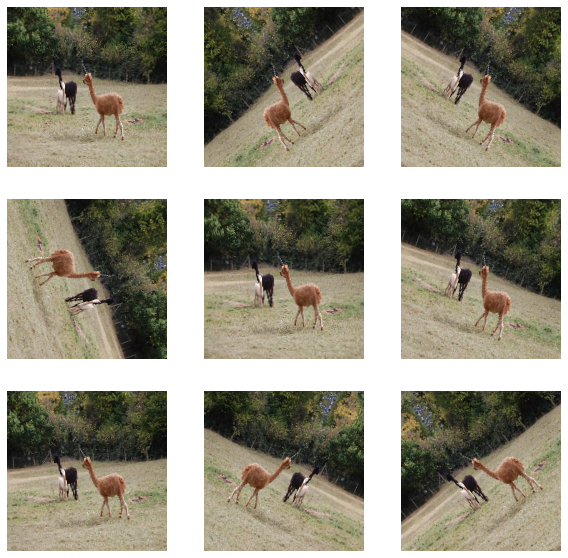

In [6]:
data_augmentation = my_data_augmenter()


plt.figure(figsize=(10, 10))
for image, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = tf.cast(tf.expand_dims(image[1], 0), tf.float32)
        augmented_image = data_augmentation(img)
        augmented_image = augmented_image.numpy().astype('uint8')[0]
        plt.imshow(augmented_image)
        plt.axis('off')

## Loading the model

MobileNetV2 is a CNN architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers. https://arxiv.org/abs/1801.04381v4

MobileNet V2 model was developed at Google, pre-trained on the ImageNet dataset with 1.4M images and 1000 classes of web images. A subset of ImageNet can be downloaded from Kaggle at: https://www.kaggle.com/c/imagenet-object-localization-challenge/overview/description

The blocks in MobileNetV2 are shown here and more details can be found in the paper:

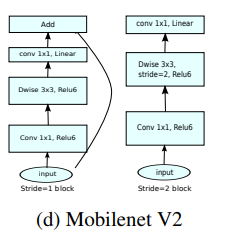

The architecture is summarized in the table 2 from the paper:

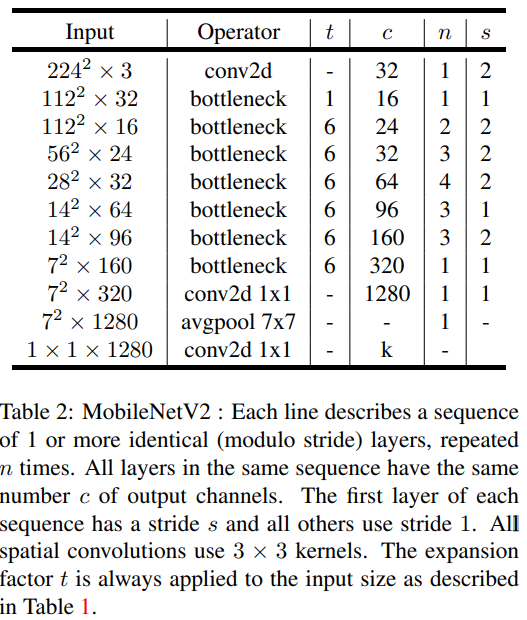 


The model and its pre-trained weight can be download from keras.applications:

In [7]:
base_model = tf.keras.applications.MobileNetV2(input_shape= IMG_SIZE + (3,),
                                               include_top=True,
                                               weights='imagenet')


## Checking the model

As usual, we can print the summary of the model and check if it makes sense.

In [8]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

### Visualizing the base model 

Before modifying the base model to create a new model for Alpaca Detection, we run a batch of data through the MobileNetV2 and see what they are classified into without any training.

In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

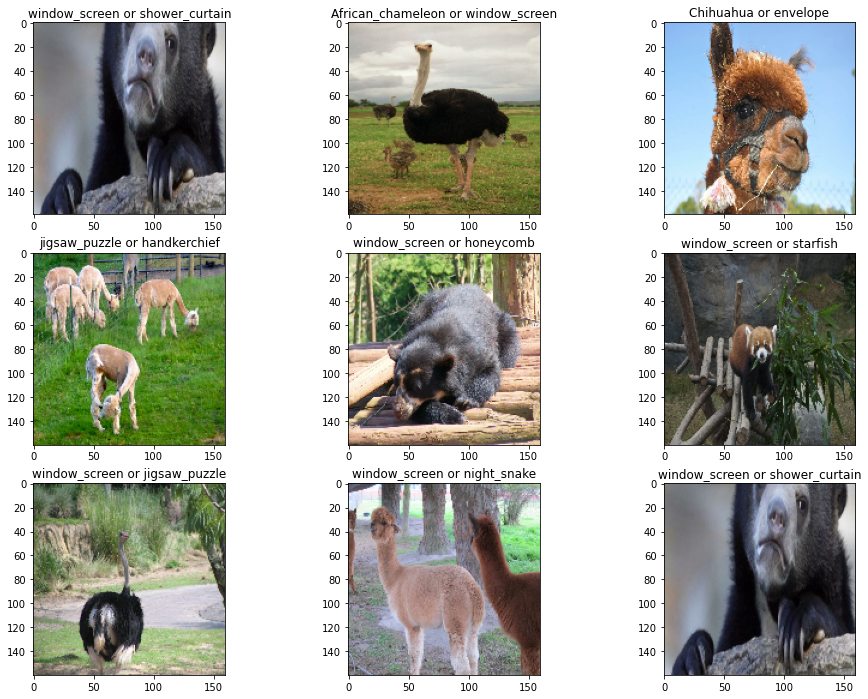

In [10]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

pred = tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

fig, ax = plt.subplots(3, 3, figsize=(16, 12))
for i in range(9):
    r = random.randint(0, image_batch.shape[0] - 1)
    im = image_batch[r].numpy().astype('uint8')
    ax[i // 3, i % 3].imshow(im)
    label = pred[r][0][1] + " or " + pred[r][1][1]
    ax[i // 3, i % 3].set_title(label)

Well, it seems the base model has no knowledge about Alpaca's. 👀 👀 👀

## Building the model

In transfer learning, where we typically want to re-purpose a model, we should inspect the last few layers. In this case, for MobileNetV2, we notice the last layers that are responsible for the classification into 1000 classes

In [11]:
num_layers = len(base_model.layers)
print(base_model.layers[num_layers - 2].name)
print(base_model.layers[num_layers - 1].name)

global_average_pooling2d
predictions


Using keras Functional API, we define a model as below:
- Input layer defining the image shape
- Our created data augmenter
- The MobileNetV2 (base_model) that does not include the last two layers (called as top)
- GlovalAveragePooling2D, coverts samples x 5 x 5 x 1280 from MobileNetV2 to samples x 1280
- Dropout, with 20% probability
- Dense, with 1 node for binary classification

In [12]:
def AlpacaDetector(image_shape=IMG_SIZE, data_augmentation=my_data_augmenter):
    
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # the last two layers are skipped
                                                   weights='imagenet')
    
    base_model.trainable = False 
    
    Inputs = tf.keras.Input(shape=input_shape) 
    X =  data_augmentation(Inputs)
    X = tf.keras.applications.mobilenet_v2.preprocess_input(X) 
    X = base_model(X, training=False)
    
    # adding the new layers
    X = layers.GlobalAveragePooling2D()(X)
    X = layers.Dropout(0.2)(X)
    Outputs = layers.Dense(1)(X)   #Binary classifier 
    
    Model = tf.keras.Model(Inputs, Outputs)
    
    return Model

### Checking the model summary to see if it makes sense:

In [13]:
Alpaca_model = AlpacaDetector(IMG_SIZE, data_augmentation)
Alpaca_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Train the model

In [14]:
Alpaca_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

initial_epochs = 20
model_history = Alpaca_model.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/20
9/9 [==============================] - 4s 257ms/step - loss: 0.7458 - accuracy: 0.5725 - val_loss: 0.6008 - val_accuracy: 0.6615
Epoch 2/20
9/9 [==============================] - 2s 197ms/step - loss: 0.5869 - accuracy: 0.6374 - val_loss: 0.4941 - val_accuracy: 0.6769
Epoch 3/20
9/9 [==============================] - 2s 201ms/step - loss: 0.5075 - accuracy: 0.7290 - val_loss: 0.4290 - val_accuracy: 0.7385
Epoch 4/20
9/9 [==============================] - 2s 199ms/step - loss: 0.4079 - accuracy: 0.7863 - val_loss: 0.3864 - val_accuracy: 0.8154
Epoch 5/20
9/9 [==============================] - 2s 199ms/step - loss: 0.4166 - accuracy: 0.7939 - val_loss: 0.3657 - val_accuracy: 0.8154
Epoch 6/20
9/9 [==============================] - 2s 196ms/step - loss: 0.2976 - accuracy: 0.8473 - val_loss: 0.3411 - val_accuracy: 0.8308
Epoch 7/20
9/9 [==============================] - 2s 194ms/step - loss: 0.3205 - accuracy: 0.8626 - val_loss: 0.3264 - val_accuracy: 0.8154
Epoch 8/20
9/9 [====

### Visualize the model performance

Plotting the accuracy and loss for both training and test data vs. epochs
We notice the there seems to be a plateau for our accuracy and that the model performance is not that great.

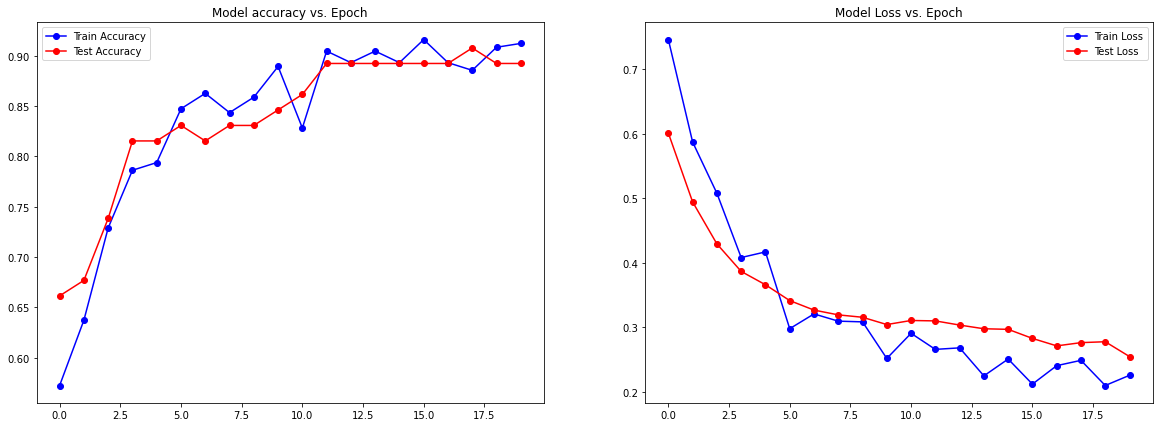

In [15]:
epochs = [i for i in range(initial_epochs)]
train_accuracy = model_history.history['accuracy']
train_loss = model_history.history['loss']
validation_accuracy = model_history.history['val_accuracy']
validation_loss = model_history.history['val_loss']

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(epochs, train_accuracy,  'bo-', label = 'Train Accuracy')
ax[0].plot(epochs, validation_accuracy,  'ro-', label = 'Test Accuracy')
ax[0].set_title('Model accuracy vs. Epoch')
ax[0].legend()


ax[1].plot(epochs, train_loss,  'bo-', label = 'Train Loss')
ax[1].plot(epochs, validation_loss,  'ro-', label = 'Test Loss')
ax[1].set_title('Model Loss vs. Epoch')
ax[1].legend()

## Improving the model

If added layers, were not enough for model training, in trasfer learning, we can always unlock some of the layers in the base model to train them for the new application. 

We need to be careful with this:
- First our dataset may be too small for all the parameters and may run into overfitting.
- We can no longer use the model for its original purpose, if we are running two models at the same time. For example, what if we wanted to classify none Alpaca images using the base model and have the alpaca detector at the same time?

Still, lets try this here and see how it can be done and improve our model.

We, re-read the base model from the Alpaca_model (at layer 5, index 4, based on the model summary above). From that we lock all the layers before layer 120 (can be changed to another value by adjusting the 'trainable_from' parameter) and let the other ones trainable. Then, we fit the data to the model again. 

In [16]:
base_model = Alpaca_model.layers[4]

base_model.trainable = True
print("Total # of layers in MobileNet: ", len(base_model.layers))

trainable_from = 120
for layer in base_model.layers[:trainable_from]:
    layer.trainable = False

Total # of layers in MobileNet:  154


### Train the improved model

Not that we can also reduce our learning rate as we are closer to the solution and perhaps don't expect big changes to the base model parameters.

In [17]:
Alpaca_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001 ),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

new_epochs = 10
total_epochs =  initial_epochs + new_epochs

new_history = Alpaca_model.fit(train_dataset,
                               epochs=total_epochs,
                               initial_epoch=model_history.epoch[-1],
                               validation_data=validation_dataset)

Epoch 20/30
9/9 [==============================] - 5s 281ms/step - loss: 0.2265 - accuracy: 0.9122 - val_loss: 0.2687 - val_accuracy: 0.9077
Epoch 21/30
9/9 [==============================] - 2s 222ms/step - loss: 0.1654 - accuracy: 0.9466 - val_loss: 0.2501 - val_accuracy: 0.8923
Epoch 22/30
9/9 [==============================] - 2s 223ms/step - loss: 0.1530 - accuracy: 0.9427 - val_loss: 0.2537 - val_accuracy: 0.9077
Epoch 23/30
9/9 [==============================] - 2s 224ms/step - loss: 0.1345 - accuracy: 0.9656 - val_loss: 0.2404 - val_accuracy: 0.9077
Epoch 24/30
9/9 [==============================] - 2s 223ms/step - loss: 0.1395 - accuracy: 0.9427 - val_loss: 0.2309 - val_accuracy: 0.9077
Epoch 25/30
9/9 [==============================] - 2s 221ms/step - loss: 0.1617 - accuracy: 0.9427 - val_loss: 0.2354 - val_accuracy: 0.9077
Epoch 26/30
9/9 [==============================] - 2s 223ms/step - loss: 0.1211 - accuracy: 0.9504 - val_loss: 0.2218 - val_accuracy: 0.9077
Epoch 27/30
9

## Visualize the improved model performance

In [18]:
train_accuracy += new_history.history['accuracy']
validation_accuracy += new_history.history['val_accuracy']

train_loss += new_history.history['loss']
validation_loss += new_history.history['val_loss']


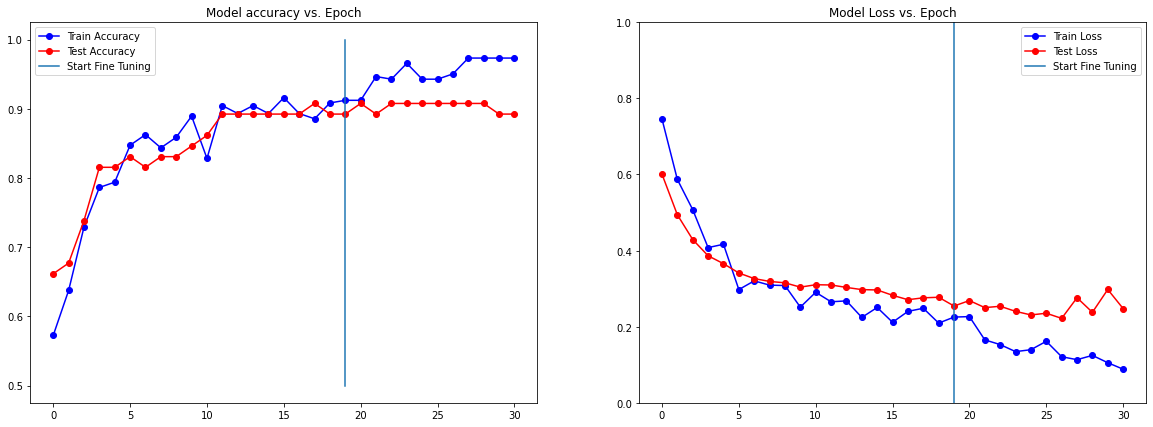

In [19]:
epochs = [i for i in range(total_epochs+1)]


fig, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].plot(epochs, train_accuracy,  'bo-', label = 'Train Accuracy')
ax[0].plot(epochs, validation_accuracy,  'ro-', label = 'Test Accuracy')
ax[0].set_title('Model accuracy vs. Epoch')
plt.ylim([0.5, 1])
ax[0].plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
#ax[0].plot.ylim([0, 1])
ax[0].legend()


ax[1].plot(epochs, train_loss,  'bo-', label = 'Train Loss')
ax[1].plot(epochs, validation_loss,  'ro-', label = 'Test Loss')
plt.ylim([0, 1])
ax[1].plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
ax[1].set_title('Model Loss vs. Epoch')
ax[1].legend()

## Notes

- We can notice the improvement after we unlock some of the layers from the basel model. This may not have been the greatest example as it seems we are overfitting (better performance on trainig but not much improvement on validation). However, it shows the concept. 
- Unlocking the base model could have been more effective if we could only run a small number of epochs.
- On my system, the training for the initial model and the improved version took around 15 sec.

#### Created by Arvin Emadi (Arvin.Emadi@Gmail.com)